In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!git clone https://github.com/korfoo12/OptMLProject OptMLProject

fatal: destination path 'OptMLProject' already exists and is not an empty directory.


In [3]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader, IterableDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.distributions.dirichlet import Dirichlet
from itertools import groupby
import random

from OptMLProject.code.lib.data_helper import *
from OptMLProject.code.lib.models import FederatedNet
from OptMLProject.code.lib.client import Client 
from OptMLProject.code.lib.plots import * 


In [4]:
#Download data
train_dataset = MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('data', train=False, download=True, transform=transforms.ToTensor())

train_dataset, dev_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.83), int(len(train_dataset) * 0.17)])

In [5]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_dev_size = len(dev_dataset)

classes = 10
input_dim = 784

num_clients = 8
rounds = 20
batch_size = 128
epochs_per_client = 3
learning_rate = 2e-2

In [6]:
device = get_device()

In [7]:
class SimpleCNN(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'linear': self.linear}
    
    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out
    
    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data, 
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict
    
    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']

In [14]:
def train_federated_learning(clients:Client,
                             train_dataset=MNIST('data', train=True, download=True, transform=transforms.ToTensor()), 
                             test_dataset=MNIST('data', train=False, download=True, transform=transforms.ToTensor()), 
                             batch_size=128,
                             rounds=20,
                             epochs_per_client=3,
                             learning_rate=2e-2,
                             optim=torch.optim.SGD,
                             momentum=None):

  device = get_device()
  global_net = to_device(FederatedNet(SimpleCNN()), device)
  train_loader = DeviceDataLoader(DataLoader(train_dataset, batch_size), device)
  test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)

  history = []
  for i in range(rounds):
      print('Start Round {} ...'.format(i + 1))
      curr_parameters = global_net.get_parameters()
      new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
      for client in clients:
          client_net = to_device(FederatedNet(SimpleCNN()), device)
          client_parameters = client.train(net=client_net, 
                                          parameters_dict=curr_parameters, 
                                          epochs_per_client=epochs_per_client, 
                                          learning_rate=learning_rate, 
                                          batch_size=batch_size,
                                          optim=optim,
                                          device=device)
          
          fraction = client.get_dataset_size() / total_train_size
          for layer_name in client_parameters:
              new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
              new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
      global_net.apply_parameters(new_parameters)
      train_loss, train_acc = global_net.evaluate(train_loader)
      dev_loss, dev_acc = global_net.evaluate(test_loader)
      print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
              round(dev_loss, 4), round(dev_acc, 4)))
      history.append((train_loss, dev_loss))
  return history

In [72]:
examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client, 
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [73]:
history_iid = train_federated_learning(clients=clients)

Start Round 1 ...
client_0: Loss = 0.5098, Accuracy = 0.8413
client_1: Loss = 0.4905, Accuracy = 0.8502
client_2: Loss = 0.4826, Accuracy = 0.8568
client_3: Loss = 0.501, Accuracy = 0.8523
client_4: Loss = 0.5106, Accuracy = 0.8377
client_5: Loss = 0.5038, Accuracy = 0.8446
client_6: Loss = 0.4937, Accuracy = 0.8471
client_7: Loss = 0.4735, Accuracy = 0.8535
After round 1, train_loss = 0.401, dev_loss = 0.3736, dev_acc = 0.8907

Start Round 2 ...
client_0: Loss = 0.3255, Accuracy = 0.9054
client_1: Loss = 0.3083, Accuracy = 0.9095
client_2: Loss = 0.3076, Accuracy = 0.9084
client_3: Loss = 0.3196, Accuracy = 0.9076
client_4: Loss = 0.3219, Accuracy = 0.9033
client_5: Loss = 0.3182, Accuracy = 0.9055
client_6: Loss = 0.3194, Accuracy = 0.9067
client_7: Loss = 0.3122, Accuracy = 0.9073
After round 2, train_loss = 0.2913, dev_loss = 0.2707, dev_acc = 0.9226

Start Round 3 ...
client_0: Loss = 0.2384, Accuracy = 0.9329
client_1: Loss = 0.2287, Accuracy = 0.9325
client_2: Loss = 0.2203, Acc

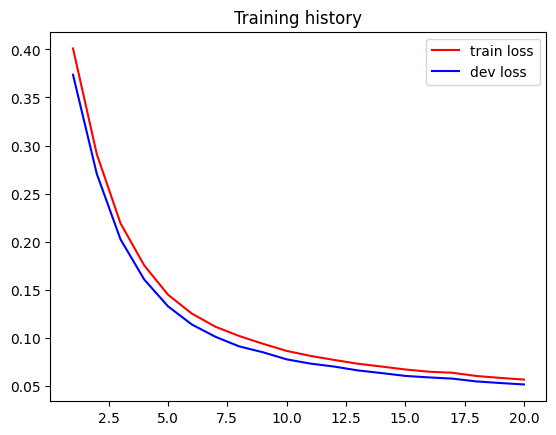

In [75]:
plot_loss_epoch(history_iid)

## Non IID DATA

In [10]:
partition = partition_by_class(train_dataset)

print(f"total # of samples : {len(train_dataset)}")
for k,v in partition.items():
    print(f" - class {k} : {len(v)}")

total # of samples : 49800
 - class 0 : 4904
 - class 1 : 5571
 - class 2 : 4924
 - class 3 : 5107
 - class 4 : 4839
 - class 5 : 4565
 - class 6 : 4908
 - class 7 : 5200
 - class 8 : 4838
 - class 9 : 4944


In [11]:
nodes = split(partition,num_clients,alpha=0.1)
for i,n in enumerate(nodes):
    print(f"node {i} :")
    for k,vs in partition_by_class(n).items():
        print(f" - class {k} : {len(vs)}")
    print(f"TOTAL      : {len(n)}\n")

node 0 :
 - class 0 : 27
 - class 3 : 3050
 - class 4 : 825
 - class 6 : 9
 - class 7 : 9
 - class 8 : 118
TOTAL      : 4038

node 1 :
 - class 1 : 1
 - class 2 : 696
 - class 3 : 6
 - class 4 : 47
 - class 5 : 2217
 - class 6 : 8
 - class 7 : 42
 - class 9 : 322
TOTAL      : 3339

node 2 :
 - class 0 : 1361
 - class 1 : 2131
 - class 3 : 226
 - class 4 : 1906
 - class 5 : 338
 - class 8 : 1
 - class 9 : 51
TOTAL      : 6014

node 3 :
 - class 1 : 1733
 - class 3 : 144
 - class 4 : 800
 - class 5 : 235
 - class 7 : 4404
TOTAL      : 7316

node 4 :
 - class 0 : 3496
 - class 1 : 1699
 - class 5 : 1775
 - class 6 : 4583
 - class 7 : 722
 - class 8 : 457
 - class 9 : 3142
TOTAL      : 15874

node 5 :
 - class 0 : 5
 - class 3 : 1678
 - class 4 : 2
 - class 6 : 230
 - class 9 : 9
TOTAL      : 1924

node 6 :
 - class 1 : 7
 - class 2 : 1
 - class 3 : 2
 - class 4 : 1259
 - class 6 : 67
 - class 8 : 4262
 - class 9 : 1420
TOTAL      : 7018

node 7 :
 - class 0 : 15
 - class 2 : 4227
 - class

In [12]:
client_datasets = nodes
clients_non_idd = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [76]:
history_simple_sgd = train_federated_learning(clients=clients_non_idd, rounds=20)

Start Round 1 ...
client_0: Loss = 0.185, Accuracy = 0.9417
client_1: Loss = 0.2157, Accuracy = 0.9635
client_2: Loss = 0.1713, Accuracy = 0.9539
client_3: Loss = 0.3268, Accuracy = 0.9083
client_4: Loss = 0.1906, Accuracy = 0.9421
client_5: Loss = 0.124, Accuracy = 0.9808
client_6: Loss = 0.4303, Accuracy = 0.8653
client_7: Loss = 0.2087, Accuracy = 0.9412
After round 1, train_loss = 1.4866, dev_loss = 1.4678, dev_acc = 0.4108

Start Round 2 ...
client_0: Loss = 0.1327, Accuracy = 0.9611
client_1: Loss = 0.1072, Accuracy = 0.9756
client_2: Loss = 0.1071, Accuracy = 0.971
client_3: Loss = 0.1688, Accuracy = 0.9437
client_4: Loss = 0.1294, Accuracy = 0.9615
client_5: Loss = 0.0586, Accuracy = 0.9889
client_6: Loss = 0.2935, Accuracy = 0.9047
client_7: Loss = 0.1518, Accuracy = 0.9539
After round 2, train_loss = 0.7145, dev_loss = 0.6871, dev_acc = 0.7679

Start Round 3 ...
client_0: Loss = 0.1105, Accuracy = 0.9671
client_1: Loss = 0.0715, Accuracy = 0.9774
client_2: Loss = 0.0851, Accu

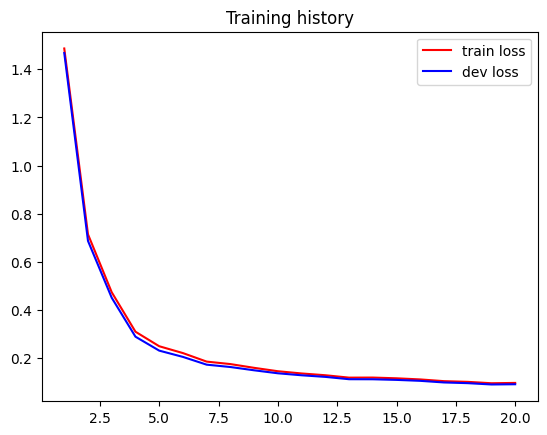

In [77]:
plot_loss_epoch(history_simple_sgd)

In [62]:
!git clone https://github.com/JianGoForIt/YellowFin_Pytorch

Cloning into 'YellowFin_Pytorch'...
remote: Enumerating objects: 1384, done.
remote: Total 1384 (delta 0), reused 0 (delta 0), pack-reused 1384
Receiving objects: 100% (1384/1384), 7.33 MiB | 20.91 MiB/s, done.
Resolving deltas: 100% (833/833), done.


In [78]:
from YellowFin_Pytorch.tuner_utils.yellowfin import YFOptimizer
optimizer = YFOptimizer
history_momentum_sgd = train_federated_learning(clients=clients_non_idd, rounds=20, optim=optimizer)

Start Round 1 ...


/content/YellowFin_Pytorch/tuner_utils/yellowfin.py:526: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self._var_list, np.sqrt(self._stat_protect_fac * self._h_max) + eps)
/content/YellowFin_Pytorch/tuner_utils/yellowfin.py:555: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self._var_list, self._exploding_grad_clip_target_value + eps)


client_0: Loss = 0.1879, Accuracy = 0.9395
client_1: Loss = 0.551, Accuracy = 0.8215
client_2: Loss = 0.1779, Accuracy = 0.95
client_3: Loss = 0.6282, Accuracy = 0.8314
client_4: Loss = 0.1594, Accuracy = 0.9532
client_5: Loss = 0.1345, Accuracy = 0.9816
client_6: Loss = 0.6021, Accuracy = 0.8142
client_7: Loss = 0.216, Accuracy = 0.9379
After round 1, train_loss = 1.4186, dev_loss = 1.3969, dev_acc = 0.4451

Start Round 2 ...
client_0: Loss = 0.1558, Accuracy = 0.9557
client_1: Loss = 0.2798, Accuracy = 0.9185
client_2: Loss = 0.1368, Accuracy = 0.9621
client_3: Loss = 0.1922, Accuracy = 0.9399
client_4: Loss = 0.1161, Accuracy = 0.9659
client_5: Loss = 0.0828, Accuracy = 0.9855
client_6: Loss = 0.3855, Accuracy = 0.9024
client_7: Loss = 0.2095, Accuracy = 0.9445
After round 2, train_loss = 0.706, dev_loss = 0.6775, dev_acc = 0.7734

Start Round 3 ...
client_0: Loss = 0.1207, Accuracy = 0.9645
client_1: Loss = 0.1276, Accuracy = 0.9749
client_2: Loss = 0.0954, Accuracy = 0.9733
client

KeyboardInterrupt: ignored

In [15]:
history_momentum_sgd = train_federated_learning(clients=clients_non_idd, rounds=10, momentum=0.9)

Start Round 1 ...
client_0: Loss = 0.1712, Accuracy = 0.9516
client_1: Loss = 0.303, Accuracy = 0.9099
client_2: Loss = 0.1642, Accuracy = 0.9538
client_3: Loss = 0.1238, Accuracy = 0.963
client_4: Loss = 0.1726, Accuracy = 0.9461
client_5: Loss = 0.1306, Accuracy = 0.9727
client_6: Loss = 0.1842, Accuracy = 0.9452
client_7: Loss = 0.0748, Accuracy = 0.9885
After round 1, train_loss = 1.3795, dev_loss = 1.3821, dev_acc = 0.6328

Start Round 2 ...
client_0: Loss = 0.0934, Accuracy = 0.9701
client_1: Loss = 0.1755, Accuracy = 0.947
client_2: Loss = 0.1085, Accuracy = 0.9671
client_3: Loss = 0.1028, Accuracy = 0.9706
client_4: Loss = 0.1351, Accuracy = 0.9616
client_5: Loss = 0.0698, Accuracy = 0.9849
client_6: Loss = 0.1297, Accuracy = 0.9596
client_7: Loss = 0.055, Accuracy = 0.9885
After round 2, train_loss = 1.0672, dev_loss = 1.0629, dev_acc = 0.6498

Start Round 3 ...
client_0: Loss = 0.068, Accuracy = 0.9772
client_1: Loss = 0.1109, Accuracy = 0.9673
client_2: Loss = 0.0797, Accura

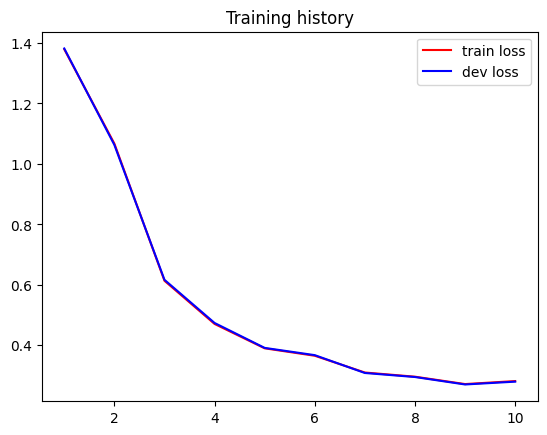

In [16]:
plot_loss_epoch(history_momentum_sgd)